In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [ ]:
X, Y = datasets.fetch_california_housing(as_frame=True, return_X_y=True)

Нормируйте значения независимых переменных из обучающей и тестовой выборок.

В качестве основной метрики качества моделей используйте MSE.

Задание 1
Обучите модели:

1. без регуляризации;
2. с Ridge-регуляризацией;
3. с Lasso-регуляризацией;
4. с ElasticNet-регуляризацией.

В каждой из моделей с регуляризацией попробуйте 10 значений гиперпараметра alpha, указанных в ячейке ниже. Выберите среди всех моделей лучшую на тестовой выборке.



In [ ]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [ ]:
Y

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422
...,...
20635,0.781
20636,0.771
20637,0.923
20638,0.847


In [ ]:
def get_result(model_class, X_train, X_test, Y_train, Y_test):
  model = model_class()
  model.fit(X_train, Y_train)
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)
  train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
  test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
  print(f"Train MSE: {train_mse}")
  print(f"Test MSE: {test_mse}")
  return model, Y_train_pred, Y_test_pred, train_mse, test_mse

In [ ]:
alphas = [0.001, 0.005 , 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
def get_result_best(model_class, X_train, X_test,Y_train, Y_test):
  best_test_mse = np.inf
  best_alpha = None

  for alpha in alphas:
    model = model_class(alpha=alpha)
    model.fit(X_train,Y_train)
    test_mse = metrics.mean_squared_error(Y_test, model.predict(X_test))
    if test_mse < best_test_mse:
      best_test_mse = test_mse
      best_alpha = alpha

  model = model_class(alpha=best_alpha)
  model.fit(X_train,Y_train)
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)
  train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
  test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
  print(f"alpha: {best_alpha}")
  print(f"Train MSE: {train_mse}")
  print(f"Test MSE: {test_mse}")
  return model, Y_train_pred, Y_test_pred, train_mse, test_mse

Разобъем дата сет случайным образом на обучающую(_train) и тестовую(_test) части

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9)

Проверим коллинеарные признаки. Для этого построим корреляционную матрицу признаков

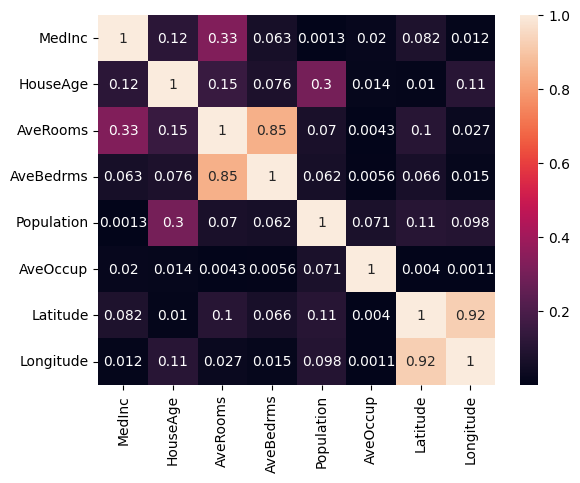

In [ ]:
sns.heatmap(np.abs(X_train.corr()), annot=True)
plt.show()

Так ну тут Широта и долгота связаны почти 0.92 корреляция что интересно, надо будет узнать

Лучшей практикой является нормирование признаков, что повышает стабильность и упрощает интерпретируемость

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_scaler.get_feature_names_out())
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_scaler.get_feature_names_out())

Будем сохранять метрики на тестовой выбрке по нашим моделям

In [ ]:
metrics_values = {
    "test_mse" : []
}
model_name = []

Линейная регрессия

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse = get_result(linear_model.LinearRegression, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
model_name.append("LinearRegression")

Train MSE: 0.5193099951108534
Test MSE: 0.5699359123545032


Рассмотрим коэффициенты признаков

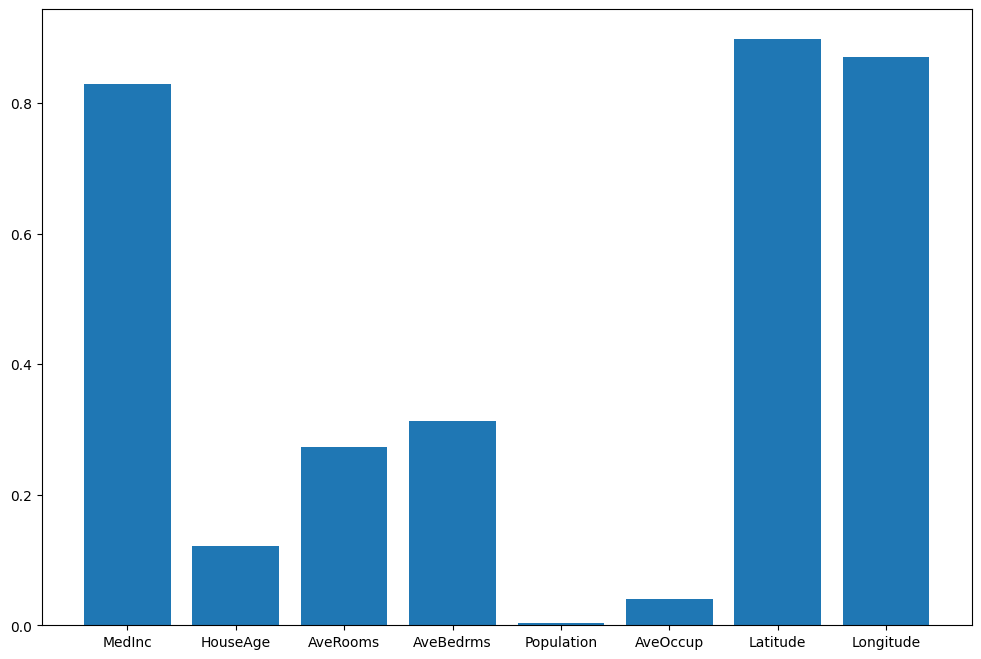

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(X_train.columns, np.abs(model.coef_))
plt.show()


Ridge регрессия с перебором гипперпараметров

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse = get_result_best(linear_model.Ridge, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
model_name.append("Ridge")

alpha: 50
Train MSE: 0.5194777947632039
Test MSE: 0.5695575087433774


Lasso Регрессия

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse = get_result_best(linear_model.Lasso, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
model_name.append("Lasso")

alpha: 0.005
Train MSE: 0.5206865597204663
Test MSE: 0.5686819408894512


ElasticNet регрессия

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse = get_result_best(linear_model.ElasticNet, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
model_name.append("ElasticNet")

alpha: 0.005
Train MSE: 0.5201591190846436
Test MSE: 0.5689968623757614


Сравним метрики

In [ ]:
pd.DataFrame(metrics_values, index=model_name)

,test_mse
LinearRegression,0.569936
Ridge,0.569558
Lasso,0.568682
ElasticNet,0.568997
